# Introduction

This notebook is one of several that I plan to make doing some data exploration of the NYC Tree Census data taken in 2015. The data can be found at the NYC OpenData website at https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh. The current version of the data is slightly different than the version that I downloaded, but overall is quite similar.

This notebook builds upon my previous study of street tree diversity in NYC neighborhoods. I include more detail there.

Some things I look at here:
- Data reduction
- Feature engineering
- Linear regression
- Nonlinear regression/Maximum likelihood
- Uncertainty estimation
- Data visualization
- k-Fold cross validation
- Validation curves
- Heteroskedasticity

### First things

First, I want to set up a couple basic things in the environment.

I'll import the basic packages I need (pandas, numpy, and matplotlib).

I will also set up the notebook so that matplotlib plots will show up.

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


### Reading the data

First, I'll read in the data. There is a "tree_id" feature in the data, but I'll leave a basic numeric index here. I also create a new feature for the tree genus using the Latin name of each species. This is easily done by combining the string split() function with a list comprehension. I am not using this right now, but in the case of smaller dataset or a dataset using a large number of species from a small number of genera, this would be a very useful feature.

There are also a number of redundant features. The Neighborhood Tabulation Area (NTA) is saved twice, as a code and as a string. Furthermore, the borough, state, and more can also be determined just from the NTA code. Here, I will save the borough and NTA information into a single separate frame for use later.

In [302]:
trees = pd.read_csv("data/street_trees_2015.csv")

def preprocess_data(trees):

    # Prepare tree with neighborhood info
    neighborhoods = trees.drop_duplicates(['nta'],keep='first')
    neighborhoods = neighborhoods[['borocode','boroname','nta','nta_name']]

    # Prepare some new features and remove many features that we won't use
    trees['genus'] = [ str(x).split()[0] for x in trees.spc_latin ]
    trees = trees[trees.status=='Alive']
    to_drop = ['stump_diam','st_assem','st_senate','zip_city','created_at',
           'address','state','cncldist','nta_name','boroname','status',
           'x_sp','y_sp','problems','spc_latin','user_type']
    trees = trees.drop(to_drop,axis=1)
    trees['health'] = trees['health'].astype('category',categories=['Good','Fair','Poor'])
    
    # Yes/no binary features
    binary_feat = ['root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other']
    for feat in binary_feat:
        trees[feat] = trees[feat].astype('category',categories=['No','Yes'])
    
    trees['sidewalk'] = trees['sidewalk'].astype('category',categories=['NoDamage','Damage'])
    trees['curb_loc'] = trees['curb_loc'].astype('category',categories=['OnCurb','OffsetFromCurb'])
    trees['guards'] = trees['guards'].astype('category',categories=['None','Helpful','Harmful','Unsure'])
    trees['steward'] = trees['steward'].astype('category',categories=['None','1or2','3or4','4orMore'])
    return trees,neighborhoods

As we saw in an earlier notebook, this will reduce the footprint of the trees DataFrame by a factor or 3.

In [303]:
trees,neighborhoods = preprocess_data(trees)

### Neighborhood Data

I can use the DataFrame.groupby() function to organize the data by different fields.
Here, I want to look at how different species of trees are distributed throughout the city. 

In [304]:
nta_counts = trees.groupby('spc_common')['nta'].value_counts()

### Defining Diversity

I defined this measure before, but I will describe it again. Basically, we are calculating the entropy of each tree when separated into the different NTAs. This is then used as a diversity score for each tree species.

Mathematically, I define the diversity of tree species $j$ to be:

\begin{equation}
S_j = - \sum\limits_{i} \frac{N_{ij}}{T_j} \log \frac{N_{ij}}{T_j}
\end{equation}

Here, $N_{ij}$ is the number of trees of species $j$ in neighborhood $i$. $T_j = \sum\limits_{i} N_{ij}$ is the total number of recorded street trees in neighborhood $i$. The sum is over all possible NYC neighborhoods (NTAs).

Now, let's consider how this statistic works. Because $N_{ij}\in \mathcal{N}\cup {0}$, $\le N_{ij}/T_{j} \le 1$ by construction. If we let
$$ f(y) = -y\log y$$
then
$$ f'(y) = - (1 + \log y) $$
and
$$ f''(y) = -\frac{1}{y} $$.

Using these equations, we see that: $f(0) = f(1) = 0$.
We can also see that $f'(1/e) = 0$ and $f(1/e) = 1/e$. Furthermore, $f''(y)<0 \forall y\in(0,1]$. These facts mean that $f(y) \ge 0 \forall y\in[0,1]$ and that $f(y)$ is a concave function over the range of $y$ that we care about.

I won't try to prove it here, but by using this definition of $S_j$, we get a measure of the diversity that is maximal when  $N_{ij} = N_{kj} \forall i,k$. I'm sure there are other measures that might be useful but this one might be best because it is well-known from physical science and also because similar statistics appear often in data science/optimization problems (see the cross-entropy loss used in many classification problems).

In [305]:
# Get the entropy/diversity from a pandas Series
def get_entropy(x):
    total = int(x.sum())
    count = len(x)
    if total == 0:
        return 0
    S = -(x/total * np.log(x/total) ).sum()
    return S,total,count

# Loop over groups from the results of a DataFrame.groupby() to get the diversity of each group.
# Save this as a DataFrame
def make_entropy_df(counts,idx_name,type_name):
    idxs = counts.index.get_level_values(0).unique()
    entropy = np.zeros(len(idxs))
    total = np.zeros(len(idxs))
    ntypes = np.zeros(len(idxs))
    for i,idx in enumerate(idxs):
        entropy[i],total[i],ntypes[i] = get_entropy(counts[idx])
    entropy_df = pd.DataFrame({'entropy':entropy,'count':total,'n_'+type_name:ntypes},index=idxs)
    entropy_df.index = entropy_df.index.rename(idx_name)
    return entropy_df

Now I'll make a plot of the diversity score (entropy) of the different tree species. Again, this diversity score measures how evenly the trees are placed around the city.

In [306]:
spc_entropy = make_entropy_df(nta_counts,'species','nta')

#nta_entropy = nta_entropy.drop(['nta'],axis=1)
spc_entropy.head()

,count,entropy,n_nta
species,,,
'Schubert' chokecherry,4888.0,4.818004,182.0
American beech,273.0,4.251582,93.0
American elm,7975.0,4.782314,187.0
American hophornbeam,1081.0,4.749918,163.0
American hornbeam,1517.0,4.774744,169.0


### Analyzing the Tree Diversity

Now, I have a dataframe with the street tree diversity of each NYC neighborhood (excluding a small number of NTAs that seem to be parks with no regular streets to include in the census).

First, we should look at the most and least diverse neighborhoods.

In [307]:
print(spc_entropy.sort_values(by='entropy')[['count','entropy','n_nta']].head())
print(spc_entropy.sort_values(by='entropy')[['count','entropy','n_nta']].tail())

               count   entropy  n_nta
species                              
Virginia pine   10.0  2.163956    9.0
black pine      37.0  2.603523   21.0
Scots pine      25.0  2.775262   18.0
Atlas cedar     87.0  3.043089   32.0
Osage-orange    29.0  3.062433   23.0
                     count   entropy  n_nta
species                                    
Sophora            19338.0  5.018533  188.0
littleleaf linden  29742.0  5.045290  188.0
honeylocust        64263.0  5.072763  188.0
American linden    13530.0  5.076243  188.0
Japanese zelkova   29258.0  5.080881  188.0


Compared to the NTA tree diversity score, these seem to cover more of hte possible phase space. With a maximal number of NTAs of 188, the maximum entropy is $-\log(1/188) = 5.24$. The top trees here are not too far off from this. We also see that the most well-spread-out trees have large counts, while the least well-spread-out trees are few in number. This is actually fairly obvious. If, for example, there are only 10 trees, the maximum possible entropy is only 2.30. So, the Virgnia pine has the worst diversity score simply because there are only 10 Virginia pines. 

To compensate, we could try to do something like normalizing each entropy by the maximum possible entropy given the number of trees of that species. Alternatively, we could instead use the tree fractions within each neighborhood rather than the raw counts. This would keep neighborhoods with huge numbers of trees from being weighted too much.

### Plotting the Data

One thing that we might worry about with this dataset is that maybe neighborhoods with few total trees tend to have much lower diversity. If this is the case, then our diversity measure will just be highly correlated with tree number, which won't be very useful. At some level, this must be true, as a neighborhood with a single tree will have a diversity score of 0. We can get a rough sense of this by looking at a scatter plot.

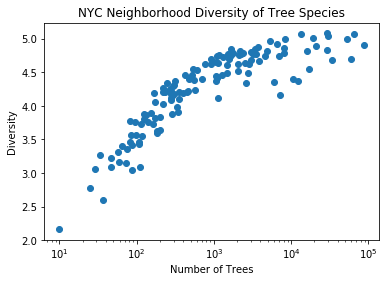

In [308]:
plt.scatter(spc_entropy['count'],spc_entropy.entropy)
plt.xscale('log')
plt.xlabel('Number of Trees')
plt.ylabel('Diversity')
plt.title('NYC Neighborhood Diversity of Tree Species')
plt.show()

The two are definitely correlated with one another, so unlike for the diversity within each neighborhood, the spread of each tree is clearly related to the total number of trees of that species within NYC.

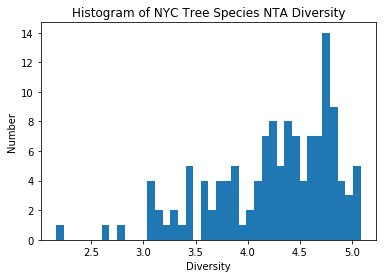

In [309]:
plt.hist(spc_entropy['entropy'],bins=40)
plt.xlabel(r'Diversity')
plt.ylabel('Number')
plt.title('Histogram of NYC Tree Species NTA Diversity')
plt.show()

The histogram definitely does not show something simple like a Gaussian distribution. This is expected from our scatter plot. There are also no huge outliers, although the lowest diversity point has a low total tree count, so we might want to consider removing it to avoid having a possibly very high leverage point. 

### Mapping the Data

I will again use my mapping tools. Here, I can plot the distributions of several tree species throughout the city.

In [310]:
from nyc.mapping import NeighborhoodMapper
from nyc.plotting import MapPlotter



First, I should only select trees with fairly large count. Let's make 1000 the minimum.

In [311]:
spc_entropy_gt1000 = spc_entropy[spc_entropy['count']>=1000]
print(spc_entropy_gt1000.sort_values(by='entropy')[['count','entropy','n_nta']].head())
print(spc_entropy_gt1000.sort_values(by='entropy')[['count','entropy','n_nta']].tail())

                      count   entropy  n_nta
species                                     
Japanese maple       1130.0  4.112338  124.0
maple                7080.0  4.158073  166.0
ash                  2609.0  4.337084  149.0
crimson king maple   5923.0  4.349666  147.0
silver maple        12277.0  4.368275  172.0
                     count   entropy  n_nta
species                                    
Sophora            19338.0  5.018533  188.0
littleleaf linden  29742.0  5.045290  188.0
honeylocust        64263.0  5.072763  188.0
American linden    13530.0  5.076243  188.0
Japanese zelkova   29258.0  5.080881  188.0


So, we see that maples seem to be very clustered, with some having a fairly large number of trees.

#### Japanese maple

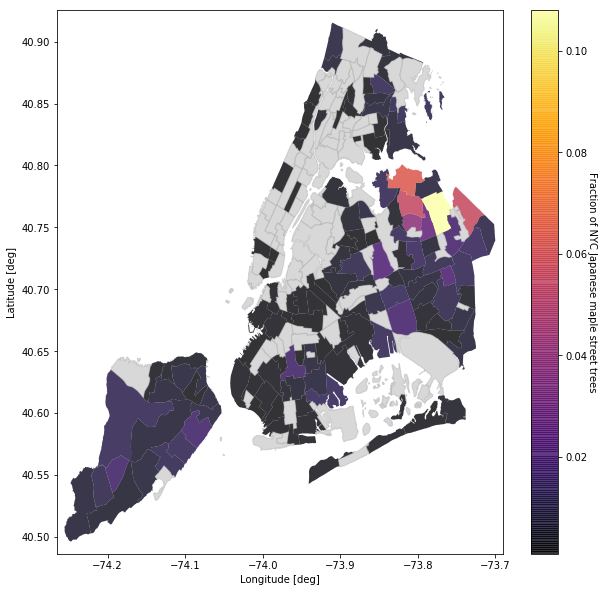

In [312]:
def plot_species_distribution(species):
    nm = NeighborhoodMapper(path='data/neighborhoods.shp')
    mp = MapPlotter(nm)

    fig = plt.figure(1,figsize=[10,10])
    ax = fig.add_subplot(111)
    values = nta_counts[species]/nta_counts[species].sum()

    mp.plot(values,ax=ax)
    mp.cbar.set_label('Fraction of NYC {} street trees'.format(species),rotation=270,labelpad=10)
    plt.show()
    
plot_species_distribution('Japanese maple')

Japanese maples are the most concentrated tree type with at least 1000 trees recorded. It looks like they are heavily concentrated in northeastern Queens.

#### Maple

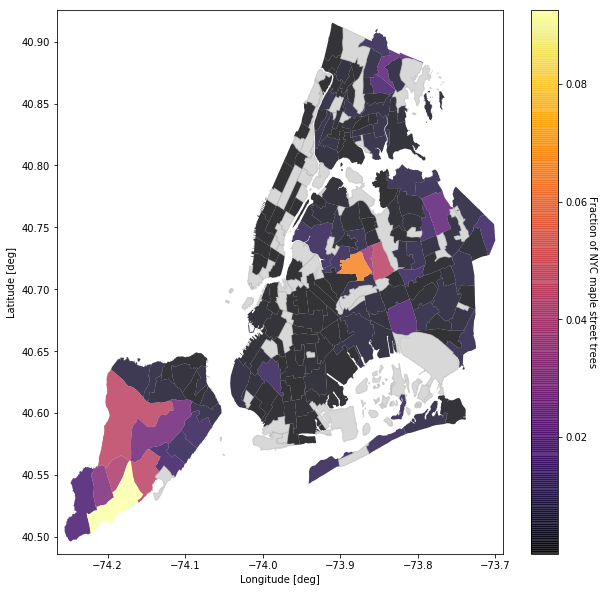

In [313]:
plot_species_distribution('maple')

Maples are mainly found in central/southern Staten Island and a few places in central Queens.

#### Silver Maple

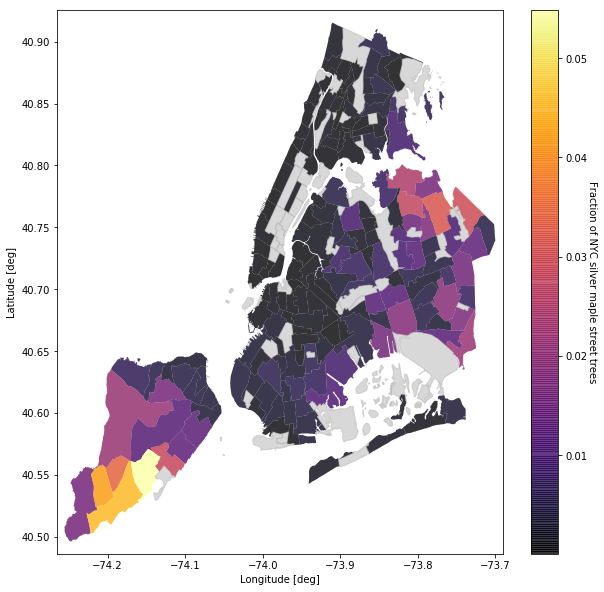

In [314]:
plot_species_distribution('silver maple')

Silver maples are concentrated in central/southern Staten Island and eastern Queens.

It is interesting that the least diverse of the fairly common trees are maples and are all mainly in Staten Island and/or Queens. Perhaps maples have trouble thriving in the most densely populated neighborhoods, so they are mostly found in more suburban areas.

#### Japanese Zelkova

Moving on to very highly spread out trees, the Japanese zelkova has the highest diversity score.

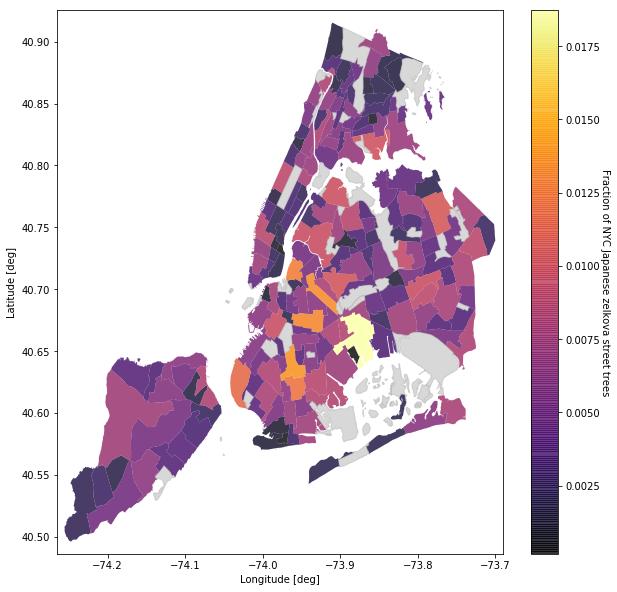

In [315]:
plot_species_distribution('Japanese zelkova')

Note the difference in the color scale compared to the earlier plots. Here, the neighborhood with the most Japanese zelkovas has only around 1.8% of the city's total. There are neighborhoods with these trees all around the city with no major concentrations or empty zones.

### American Linden

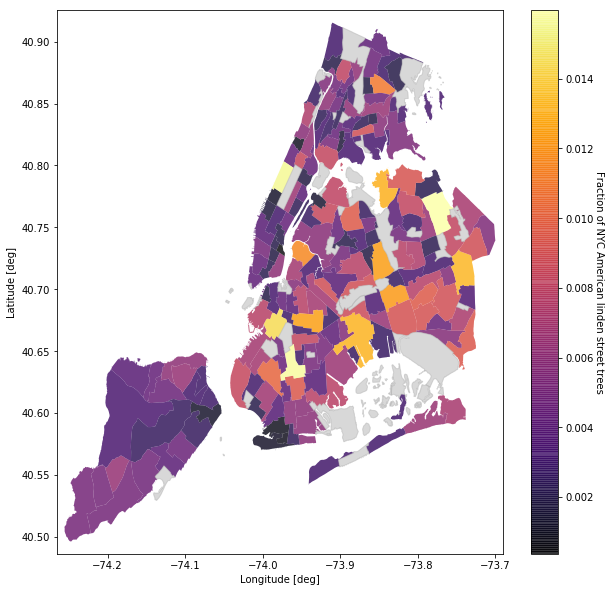

In [316]:
plot_species_distribution('American linden')

The American linden looks pretty similar to the Japanese Zelkova. Staten Island seems to not have any areas with a lot of these but, again, no neighborhood has more than around 1.5% of the city's American Lindens. These also appear in many different locations. The Upper West Side has one of the highest concentrations, but there are many areas in Brooklyn and Queens with fairly large numbers too. I would guess that the American linden can thrive in many kinds of urban environments.

### Linear Regression: How Much Does Diversity Depend on Total Tree Count

There is clearly a correlation between tree count and how well it is spread throughout NYC. Luckily, I built some code in the previous notebook to see what kind of polynomial will look best. I'll just copy the code over here. At some point, it may be advantageous to put this sort of code into a module to avoid copy-pasting too much.

In [317]:
# First, create some new polynomial features:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
poly_feat = PolynomialFeatures(degree=10)
spc_entropy['LogCount'] = np.log10(spc_entropy['count'])
X = poly_feat.fit_transform(spc_entropy[['LogCount']])
y = spc_entropy['entropy']

# Our features now include a constant value
lr = LinearRegression(fit_intercept=False)

kf = KFold(n_splits=5,random_state=999,shuffle=True)
# I'll use the same sets for each of the models

r2_train = np.zeros([5,11])
r2_val = np.zeros([5,11])
# more on these next two later
r2_train_adj = np.zeros([5,11])
r2_val_adj = np.zeros([5,11])
fold = 0
for train_idx,val_idx in kf.split(X):
    X_train = X[train_idx,:]
    y_train = y[train_idx]
    X_val = X[val_idx,:]
    y_val = y[val_idx]
    n_tr = y_train.shape[0]
    n_val = y_val.shape[0]
    
    for i in range(11):
        lr.fit(X_train[:,:i+1],y_train)
        R2 = lr.score(X_train[:,:i+1],y_train)
        r2_train[fold,i] = R2
        r2_train_adj[fold,i] = R2 - (1-R2) * i/(n_tr-i-1)
        R2 = lr.score(X_val[:,:i+1],y_val)
        r2_val[fold,i] = R2
        r2_val_adj[fold,i] = R2 - (1-R2) * i/(n_val-i-1)
    fold += 1

As in the last notebook, I'll now plot validation curves for $R^2$ and adjusted $R^2$.

In [318]:
def plot_validation_curve(r2_train,r2_val,ylabel=r'R$^2$ Score'):
    r2_tr_mean = np.mean(r2_train,axis=0)
    r2_tr_std = np.std(r2_train,axis=0)
    r2_val_mean = np.mean(r2_val,axis=0)
    r2_val_std = np.std(r2_val,axis=0)
    xvals = np.array([1.0*x for x in range(11)])
    plt.errorbar(xvals,r2_tr_mean,yerr=r2_tr_std,label='Test')
# Offset this by a bit to avoid blocking the first plot
    plt.errorbar(xvals+0.1,r2_val_mean,yerr=r2_val_std,label='Validation',c='r')

    plt.xlabel('Polynomial Order')
    plt.ylabel(ylabel)
    plt.title('Validation Curve')
    plt.ylim([0,1])
    plt.legend(loc='upper left')
    plt.show()

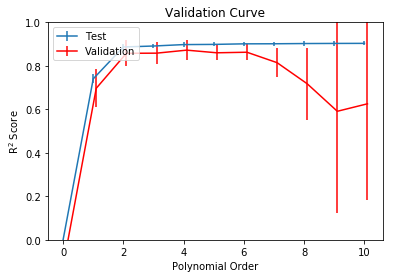

In [319]:

plot_validation_curve(r2_train,r2_val)

Unlike my earlier notebook looking at neighborhood tree diversity, this validation curve shows some sensible results, as a fit is fairly effective.

From the $R^2$ scores, we that 2nd through 6th order polynomials give almost equivalent scores for both the test and validation sets. On the test set, there is an $R^2$ curve of around 0.9 while for the validation set, it is slightly lower, around 85%.

But how does the adjusted $R^2$ score look?



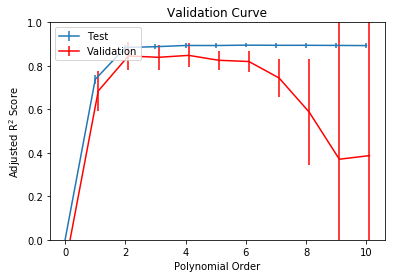

In [320]:
plot_validation_curve(r2_train_adj,r2_val_adj,ylabel=r'Adjusted R$^2$ Score')

This is vey similar. Second through 5th or 6th order polynomials give very similar results again. Let's now compare the quadratic and quintic fits.

In [321]:
def plot_1d_regression(x,y,linregs,xlabel,ylabel,title,lr_labels,lr_colors,
                       minx=0.5,maxx=6,npts=200):
    idxs = np.argsort(x)
    x = x[idxs]
    y = y[idxs]
    fitx = np.mgrid[minx:maxx:npts*1j]
    
    yfit = np.zeros([len(linregs),npts])
    yres = np.zeros([len(linregs),x.shape[0]])
    # Get fit curves
    for lr_idx,lr in enumerate(linregs):
        for idx,xval in enumerate(fitx):
            xtmp = 1
            coeffs = lr.coef_
            if type(coeffs[0])==np.ndarray:
                coeffs = coeffs[0]
            for coef in coeffs:
                yfit[lr_idx,idx] += coef * xtmp
                xtmp *= xval

    # Get fit residuals
    for lr_idx,lr in enumerate(linregs):
        for idx,xval in enumerate(x):
            xtmp = 1
            coeffs = lr.coef_
            if type(coeffs[0])==np.ndarray:
                coeffs = coeffs[0]
            for coef in coeffs:
                yres[lr_idx,idx] += coef * xtmp
                xtmp *= xval
            yres[lr_idx,idx] = y[idx]-yres[lr_idx,idx]
                
    fig = plt.figure(1,figsize=(5+5*len(linregs),5))
    ax = fig.add_subplot(1,len(linregs)+1,1)
    ax.scatter(x,y,label='data',c='b')
    for i in range(len(linregs)):
        ax.plot(fitx,yfit[i,:],label=lr_labels[i],c=lr_colors[i])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    for i in range(len(linregs)):
        ax = fig.add_subplot(1,len(linregs)+1,i+2)
        ax.hist(yres[i,:],bins=20)
        ax.set_xlabel('Residual')
        ax.set_ylabel('Number of Points')
        ax.set_title('Histogram of Residuals, {}'.format(lr_labels[i]))
    plt.show()
    return x,yres

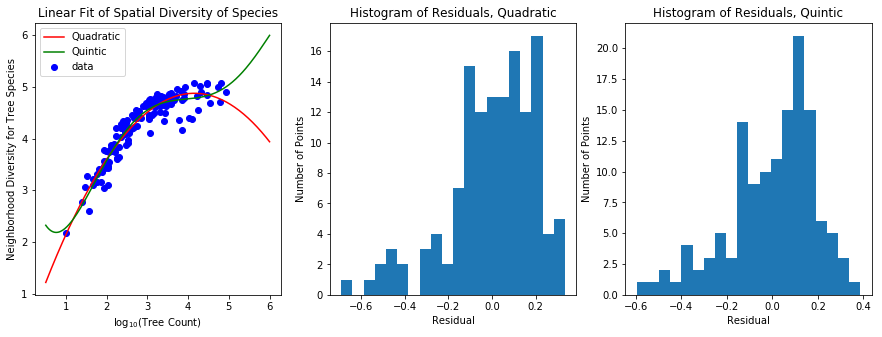

In [322]:
lr2 = LinearRegression(fit_intercept=False)
lr5= LinearRegression(fit_intercept=False)

lr2.fit(X[:,:3],y)
lr5.fit(X[:,:6],y)


x,yres = plot_1d_regression(X[:,1],y,[lr2,lr5],
                   r'log$_{10}$(Tree Count)',
                   'Neighborhood Diversity for Tree Species',
                   'Linear Fit of Spatial Diversity of Species',
                   ['Quadratic','Quintic'],
                   ['r','g']
                  )



We see that the two fits provide very similar results for the region where we have data. If we try to extend the fits outside the fit range to make predictions, we see very different results. The quintic fit turns sharply upward at both ends, while the quadratic is dropping sharply at either end. There is also at least one missing local extreme point in the quintic, since the asymptotic behavior is to be $p_5(x)\sim A x^5$.

The residuals are not perfectly Gaussian as we would really like, but they don't look so bad. It also looks like the width is fairly constant as a function of tree count, so heteroskedasticity is at least not a huge problem here. It looks like the lowest tree count point does have a high amount of leverage, so it may be significantly constraining the fits. However, the validation curves suggest that this is not too important for us here. But, how might we quantify heteroskedasticity?

#### Heteroskedasticity

Note that I returned the residuals from the fits. One thing we can do for a 1-dimensional problem like this is to see how the width of the residuals changes from point to point. An easy way to look at this is to take one of the fits and then plot the standard deviation for different subsets of points. The plot is reasonably evenly spread over tree counts, so we will just use some fixed number of points for each calculation.

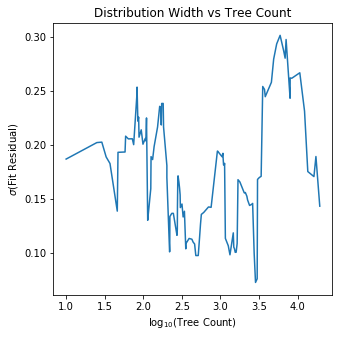

In [323]:
def plot_heteroskedasticity(x,y,Npts=10):
    sorted_idxs = np.argsort(x)
    x = x[sorted_idxs]
    y = y[sorted_idxs]
    xplot = x[:-Npts+1]
    yplot = np.zeros(len(xplot))
    for i in range(len(xplot)):
        yplot[i] = np.std(y[i:i+Npts])
        
    fig = plt.figure(1,figsize=[5,5])
    ax = fig.add_subplot(111)
    ax.plot(xplot,yplot)
    ax.set_xlabel(r'log$_{10}$(Tree Count)')
    ax.set_ylabel(r'$\sigma$(Fit Residual)')
    ax.set_title('Distribution Width vs Tree Count')
    plt.show()
    
plot_heteroskedasticity(x,yres[0,:])
    


So, we see that there is a lot of scatter in the width, but there isn't really a clear trend. There is a big spike near the end, but things settle back down to near the average. If we saw an obvious trend, we might want to consider transforming the diversity count before fitting to reduce heteroskedasticity or we could even go to a $\chi^2$ fit by adding an approximate error term to improve the model. Of course, the measurement error here is likely very small and is not present within the data available, so an error term would just be to account for a changing spread in values and not an actual error on the points. Many statistical tests assume that there is no heteroskedasticity, so depending on what we want to do with the data, it may be necessary to do a serious investigation in some analyses. Realistically, we probably want more data points before trusting this too much.

#### Extracting Independent Variables

Now that we have some fits of the diversity score as a function of tree count, we can make two approximately independent variables: The tree count and the fit residual. 

In [326]:
#print(X[0,:])
spc_entropy['Residual'] = spc_entropy['entropy'] - lr2.predict(X[:,:3])

print('Original Covariance')
print(spc_entropy[['LogCount','entropy']].cov())

print('\n\nUsing Fit Residual')
print(spc_entropy[['LogCount','Residual']].cov())
# We'll see a huge reduction in the off-diagonal terms

Original Covariance
          LogCount   entropy
LogCount  0.703698  0.427375
entropy   0.427375  0.350486


Using Fit Residual
              LogCount      Residual
LogCount  7.036985e-01  2.050692e-16
Residual  2.050692e-16  3.962767e-02


#### Nonlinear Regression

As I mentioned, the polynomial fits give poor results if we try to extend them beyond the range of the fit. We could instead define a different function that will be a bit more stable. A rational function might work. If the denominator and numerator are the same order, then the asymptotic behavior at large tree counts would be a constant, which is what we might want for a bounded function like an entropy. Lets try the ratio of two lines, $R(x)$. $R(x)$ will be a constant at high $x$ and a line at low $x$, which looks like it will approximate our data well.

In [327]:

X = spc_entropy['LogCount'].as_matrix()
y = spc_entropy['entropy'].as_matrix()

# Set one of the coefficients to 1 in order to avoid
# having a continuum of equivalent results.
def rational_func(x,C):
    if np.sum(1*((1 + C[2]*x) == 0)>0):
        return 1e9 # a large number
    return (C[0] + C[1]*x) / (1 + C[2]*x)

# A log-likelihood function for a least-squares objective
# Not including any error term (or, variance = 1)
def logll(C):
    pred = rational_func(X,C)
    logll = 0.5 * (pred-y)*(pred-y)
    logll = np.sum(logll)
    return logll

# The gradient: First derivatives of the objective
# Needed by some minimizers
def logll_deriv(C):

    N = C[0] + C[1] * X
    invD = 1.0 / (1 + C[2] * X)
    
    dA = np.sum( (N*invD - y)*invD)
    dB = np.sum((N*invD - y)*invD* X)
    dC = np.sum(-(N*invD-y)*N*invD*invD*X)
    
    return np.array([dA,dB,dC])

# Also needed by some algorithms
def logll_hessian(C):
    hess = [[0,0,0],[0,0,0],[0,0,0],[0,0,0]]
    hess_mat = np.zeros([3,3])
    N = C[0]+C[1]*X
    D = 1+C[2]*X
    hess[0][0] = 1./(D*D)
    hess[0][1] = X * hess[0][0]
    hess[0][2] = X*(-2*N/(D*D*D) + y/(D*D))
    hess[1][0] = hess[0][1]
    hess[1][1] = X*X*hess[0][0]
    hess[1][2] = X * hess[0][2]
    hess[2][0] = hess[0][2]
    hess[2][1] = hess[1][2]
    hess[2][2] =X*X*(3 * N * N / (D*D*D*D) - 2*N*y/(D*D*D))


    for i in range(3):
        for j in range(3):
            hess_mat[i,j] = np.sum(hess[i][j])
    return hess_mat

In [328]:
from scipy.optimize import minimize

# pick some initial values
#x0 = [0,5,1]
x0 = np.array([-10,15,2])
#result = minimize(logll,x0,method='Nelder-Mead',options={'disp':True,'xatol':1e-5})

#result = minimize(logll,x0,method='powell',options={'disp':True})
#result = minimize(logll,x0,method='BFGS',jac=logll_deriv,options={'disp':True})

# Documentation says fast and accurate but needs gradient and Hessian
result = minimize(logll,x0,method='Newton-CG',jac=logll_deriv,hess=logll_hessian,options={'disp':True,'xtol':1e-8})

print('Result:')
print(result)


Optimization terminated successfully.
         Current function value: 2.985306
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 25
         Hessian evaluations: 12
Result:
     fun: 2.9853063202443062
     jac: array([  1.36062005e-08,  -1.19283871e-08,  -1.63075864e-09])
 message: 'Optimization terminated successfully.'
    nfev: 14
    nhev: 12
     nit: 12
    njev: 25
  status: 0
 success: True
       x: array([-10.48440777,  17.11767192,   2.73426794])


Fit R2: 0.87
Fit Adjusted R2: 0.867
Variance of residuals: 0.04523


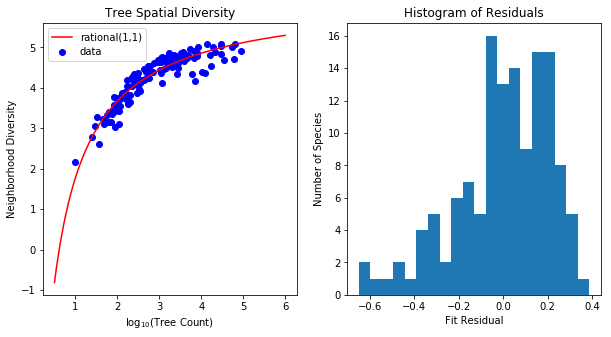

In [329]:

xplot = np.mgrid[0.5:6:200*1j]
yplot = rational_func(xplot,result.x)
ypred = rational_func(X,result.x)

# using the sklearn r2_score function
from sklearn.metrics import r2_score
r2 = r2_score(y,ypred)
n = y.shape[0]
p = 3
r2_adj = r2 - (1-r2) * p/(n-p-1)

print('Fit R2: {:0.3}'.format(r2))
print('Fit Adjusted R2: {:0.3}'.format(r2_adj))
print('Variance of residuals: {:0.4}'.format(np.var(y-ypred)))
res_var = np.var(y-ypred)
fig = plt.figure(1,[10,5])
ax = fig.add_subplot(121)
ax.scatter(X,y,label='data',c='b')
ax.plot(xplot,yplot,label='rational(1,1)',c='r')
ax.legend(loc='upper left')
ax.set_xlabel(r'log$_{10}$(Tree Count)')
ax.set_ylabel('Neighborhood Diversity')
ax.set_title('Tree Spatial Diversity')
ax = fig.add_subplot(122)
ax.hist(y-ypred,bins=20)
ax.set_xlabel('Fit Residual')
ax.set_ylabel('Number of Species')
ax.set_title('Histogram of Residuals')
plt.show()

This function seems to not do quite as well as the polynomials, but it should generalize better to some data due to its better stability as we go outside the fit range. Perhaps a ratio of quadratics will be better. I won't do that here, but it's easy to see how. The tricky thing will be picking some initial conditions.

#### Fit Errors in the Nonlinear Fit

There are several ways that we can calculate errors in the nonlinear fit. One simple way is if we assume that the likelihood is roughly a multivariate Gaussian. Then, the inverse covariance of the distribution is going to be the Hessian matrix of the log-likelihood function. Luckily, this is a function where we can get an exact Hessian.  

To see why the Hessian will give us approximate errors, consider the multivariate $n$-dim. Gaussian with some covariance $\mathbf{\Sigma}$. Then the distribution is:

\begin{equation}
f(\mathbf{x}|\mathbf{\mu},\mathbf{\Sigma}) = \frac{1}{(2\pi)^{n/2}\sqrt{|\mathbf{\Sigma}|}}\exp\left(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu})\right)
\end{equation}

Here, $f$ is a function of our parameters and has some optimum parameters $\mathbf{\mu}$. The log-likelihood, then is just 

\begin{equation}
LL(\mathbf{x}|\mathbf{\mu},\mathbf{\Sigma}) = -\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu})
\end{equation}

after removing constant terms. Typical optimizers minimize, so we want to use $-LL$ as our objective function. We can then calculate the terms of the Hessian matrix for the objective function:

\begin{equation}
H_{ij} = \frac{\partial^2 }{\partial x_i \partial x_j}(-LL) = \mathbf{\Sigma}^{-1}_{ij}
\end{equation}

so we see that if we assume the likelihood function is a multivariate Gaussian function of the fit parameters, the Hessian gives us the inverse parameter covariance matrix.

However, it is important to note that because I did not add an error term, the scale of the Hessian is not meaningful. To get a covariance, I should multiply the inverse Hessian by some approximate error scale.

Gradient:
[  1.36062005e-08  -1.19283871e-08  -1.63075864e-09]
Hessian:
[[   2.05102801    5.05485376  -20.83470885]
 [   5.05485376   13.68422906  -58.66663038]
 [ -20.83470885  -58.66663038  255.34190208]]


Covariance
[[ 41.44034874 -54.12179755  -9.05353126]
 [-54.12179755  70.90446602  11.87472241]
 [ -9.05353126  11.87472241   1.9897537 ]]


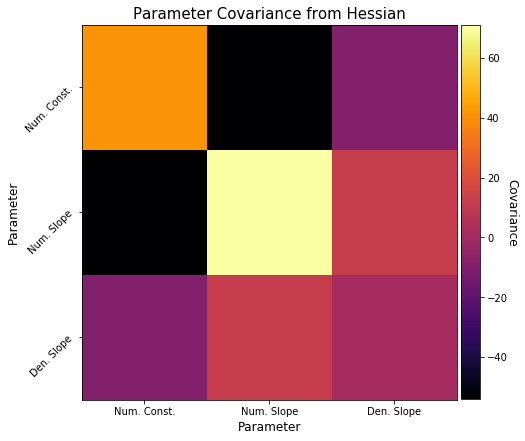

In [330]:
hess = logll_hessian(result.x)
deriv = logll_deriv(result.x)


print('Gradient:')
print(deriv)

print('Hessian:')
print(hess)

# For a simple error, take the variance of the residuals
# In this dataset, the true error on a measurement will be much smaller
# so even this will be a large overestimate of the errors.
# The correlations, however, should be correct.
cov = np.linalg.inv(hess) * res_var

print('\n\nCovariance')
print(cov)
fig = plt.figure(1,figsize=[8,8])
ax = fig.add_subplot(111)
im = ax.imshow(cov,cmap='inferno')
ax.set_xlabel('Parameter',fontsize=12)
ax.set_xticks(range(3))
ax.set_xticklabels(['Num. Const.','Num. Slope','Den. Slope'])
ax.set_ylabel('Parameter',fontsize=12)
ax.set_yticks(range(3))
ax.set_yticklabels(['Num. Const.','Num. Slope','Den. Slope'],rotation=45)
ax.set_title('Parameter Covariance from Hessian',fontsize=15)
cbar = fig.colorbar(im,ax=ax,shrink=0.86,pad=0.01)
cbar.set_label('Covariance',rotation=270,labelpad=10,fontsize=12)
plt.show()

We see some pretty strong correlations between the variables here. With the error used for this calculation, the uncertainties are actually quite large. Again, this is likely a large overestimate, so a more accurate error value will give much smaller uncertainties. There are other ways to check the covariance in case the Gaussian assumption breaks down. Using a Markov Chain Monte Carlo should be more accurate, as it can sample over the whole parameter space if tuned properly.

### Conclusions

For this notebook, we've gone over how spread out over NYC different tree species are. We've found that the number of street trees of a given species is highly correlated with how spread out that species is, but we can try to fit for this relation in order to remove the correlation and get an independent feature related to the diversity score used to quantify how trees are spread over different neighborhoods.

We've also looked at different methods of fitting, including a basic linear regression and a nonlinear regression.